In [541]:
from IPython.display import Markdown
from scipy.stats import norm
from scipy.spatial.distance import directed_hausdorff
import numpy as np 
import networkx as nx
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from random import random, randint
from numpy.random import choice
from operator import add

In [542]:
from pymongo import MongoClient

client = MongoClient()
db = client.recipe_db
recipes = db.recipes

In [543]:
from collections import Counter
import seaborn
import pandas as pd
import math

In [848]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Reshape, MaxPooling2D
from keras.models import load_model
import h5py

In [545]:
%run "./Show_Recipes.ipynb"

In [546]:
%run "./Get_Recipes.ipynb"

In [547]:
%run "./Parse_Recipes.ipynb"

## Global Variables

In [697]:
# note, a few values are hard coded in-line

min_rating_count = 10
good_rating = 2.0/4
master_list_of_ing = None
master_list_of_units = None
amounts_fulllist = None
amounts_list = None
master_list_of_heat = [u'no', u'low', u'medium', u'high', u'very high']

In [549]:
def select_rated_recipes():
    rated_recipes = db.rated_recipes
    rated_recipes.remove()
    rated_list = list(recipes.find({ 'rating_count': { '$gte': min_rating_count } }))
    save_recipes(rated_list, rated_recipes)
    return rated_recipes


## Visualizations

In [550]:
def unit_name(x):
    if x == 'lb':
        return 'pound'
    elif x == 'kg' or x == 'kilo':
        return 'kilogram'
    elif x == 'g':
        return 'gram'
    elif x == 'Handful' or x == 'fistful':
        return 'handful'
    elif x == 'quarter':
        return 'quarters'
    elif x == 'glas':
        return 'glass'
    elif x == 'Tablespoon' or x == 'spoonful' or x == 'tablespoons':
        return 'tablespoon'
    elif x == 'split':
        return None
    else:
        return x

total recipes 9534
rated recipes 3381
good recipes 3381
bad recipes 1605


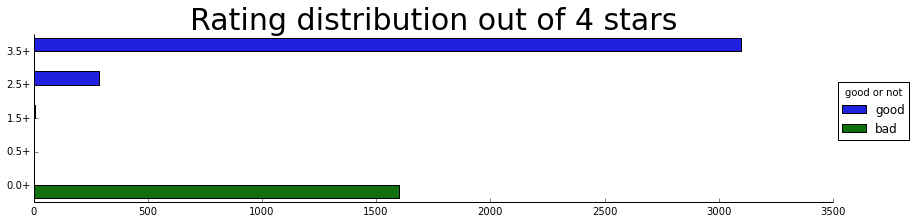

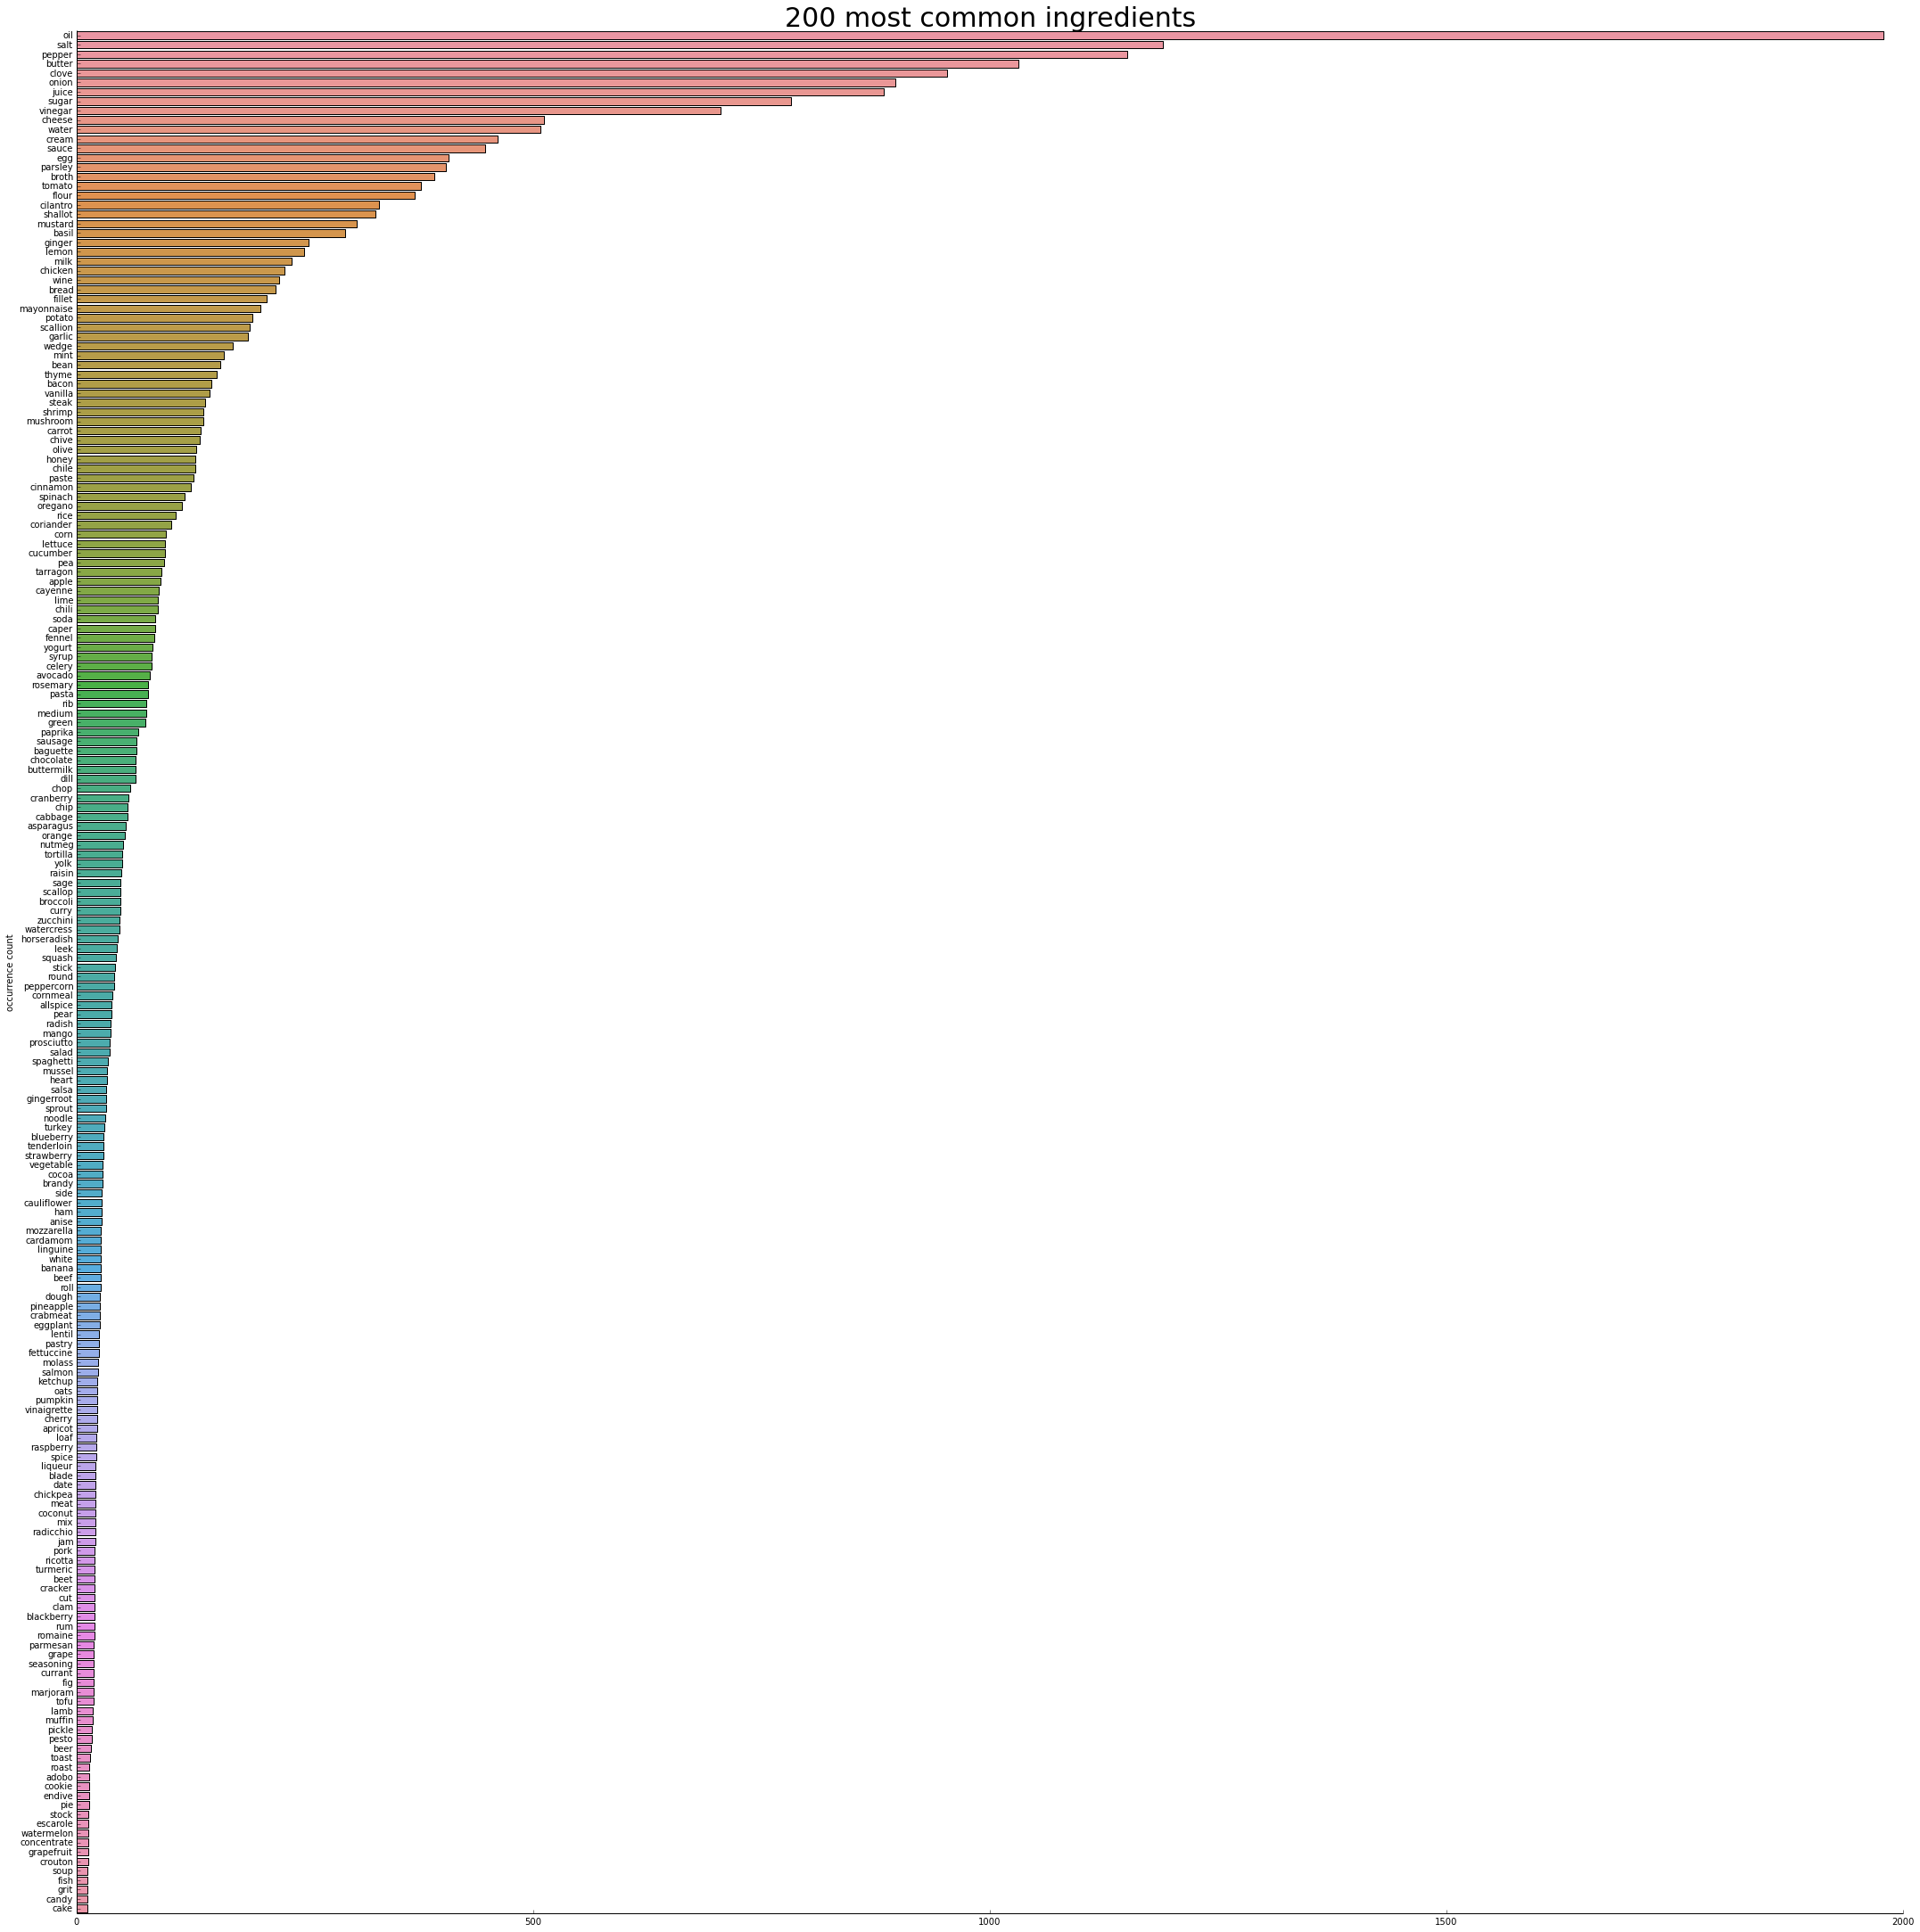

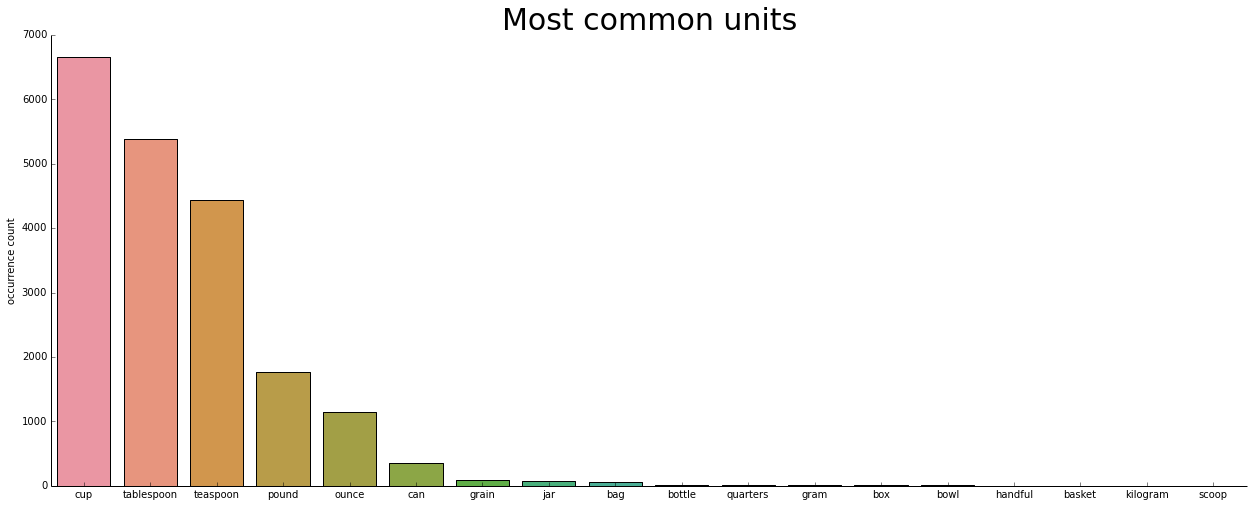

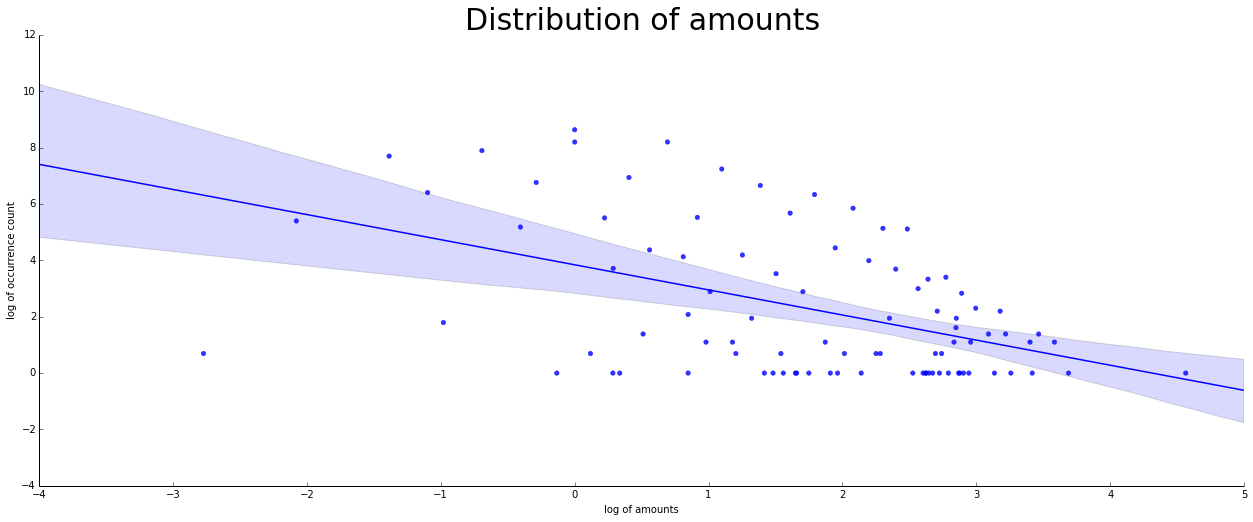

In [698]:
def visualize():
    print "total recipes " + str(recipes.find().count())
    rated_recipes = select_rated_recipes()
    good_recipes = rated_recipes.find({ 'rating': { '$gte': good_rating },
                                'rating_count': { '$gte': min_rating_count }}).count()
    bad_recipes = rated_recipes.find({ 'rating': { '$lt': good_rating },
                               'rating_count': { '$gte': min_rating_count }}).count()
    
    recipe_list = rated_recipes.find({ 'rating': { '$gte': good_rating },
                                'rating_count': { '$gte': min_rating_count }})
    recipe = next(recipe_list, None)
    
    ingredients = Counter([])
    units = Counter([])
    amounts = Counter([])
    global amounts_fulllist
    amounts_fulllist = []
    
    i = 0
    while recipe:
        i += 1
        ingredients.update(recipe['ingredients'].keys())
        units.update([unit_name(x['unit']) for x in recipe['ingredients'].values()])
        recipe = next(recipe_list, None)
        
    global master_list_of_ing
    master_list_of_ing = ingredients.keys()
    global master_list_of_units
    master_list_of_units = [x[0] for x in units.most_common()[:6]]
    
    recipe_list = rated_recipes.find({ 'rating': { '$gte': good_rating },
                                'rating_count': { '$gte': min_rating_count }})
    recipe = next(recipe_list, None)
    
    i = 0
    while recipe:
        i += 1
        for x in recipe['ingredients'].values():
            if unit_name(x['unit']) in master_list_of_units:
                amounts.update([x['amount']])
                amounts_fulllist.append(x['amount'])
        recipe = next(recipe_list, None)

    global amounts_list
    amounts_sum = sum(amounts.values())
    amounts_list = dict([(x, amounts[x] * 1.0 /amounts_sum) for x in amounts.keys()])
        
    print "rated recipes " + str(i)
    print "good recipes " + str(good_recipes)
    print "bad recipes " + str(bad_recipes)   
    
    data = pd.DataFrame({'rating': ['3.5+', '2.5+', '1.5+', '0.5+', '0.0+'], 'count': [
                rated_recipes.find({ 'rating': { '$gte': 3.5/4 } }).count(),
                rated_recipes.find({ 'rating': { '$gte': 2.5/4, '$lt': 3.5/4 } }).count(),
                rated_recipes.find({ 'rating': { '$gte': 1.5/4, '$lt': 2.5/4 } }).count(),
                rated_recipes.find({ 'rating': { '$gte': 0.5/4, '$lt': 1.5/4 } }).count(),
                rated_recipes.find({ 'rating': { '$gte': 0.0/4, '$lt': 0.5/4 } }).count()
            ]})
    
    #rating
    data["good or not"] = ['good', 'good', 'good', 'bad', 'bad']
    seaborn.factorplot(y="rating", x="count", hue="good or not", data=data[:5], kind='bar', size=3, aspect=4)\
        .set_axis_labels("", "").ax.set_title("Rating distribution out of 4 stars", fontsize=30)
    
    #ingredients list
    data = pd.DataFrame({'ingredient': [x[0] for x in ingredients.most_common()], \
                         'count': [x[1] for x in ingredients.most_common()]})
    seaborn.factorplot(y="ingredient", x="count", data=data[:200], kind='bar', size=30, aspect=1)\
        .set_axis_labels("", "occurrence count").ax.set_title("200 most common ingredients", fontsize=30)
    
        
    #units list
    data = pd.DataFrame({'unit': [x[0] for x in units.most_common()], 'count': [x[1] for x in units.most_common()]})
    seaborn.factorplot(x="unit", y="count", data=data, kind='bar', size=7, aspect=2.5)\
        .set_axis_labels("", "occurrence count").ax.set_title("Most common units", fontsize=30)
    
    #amounts range
    data = pd.DataFrame({'amount': [0 if x[0] == 0 else math.log(x[0]) for x in amounts.most_common()], \
                         'count': [math.log(x[1]) for x in amounts.most_common()]})
    seaborn.lmplot(x="amount", y="count", data=data, size=7, aspect=2.5)\
        .set_axis_labels("log of amounts", "log of occurrence count").ax.set_title("Distribution of amounts", fontsize=30)
    
    
visualize()
(mu, sigma) = norm.fit(amounts_fulllist)

## Global Variables

In [675]:
reproduction_ratio=2.0/10
chance_to_mutate=0.75
random_select=0.05

max_ing = 15
min_ing = 3
max_steps = 30
max_gen_steps = 15

## Genetic Algorithm - Generator

In [553]:
# # punished for being similar to any of the existing recipes
import copy

In [738]:
def individual(gen_index, gen):
    """Creat a member of the population."""
    recipe = {'source': None}
    recipe['title'] = 'Recipe %(x)i Gen %(gen)i' % {'x': gen_index, 'gen': gen}
    
    # pick list of ing & corresponding amts
    num_ing = choice(xrange(min_ing, max_ing + 1))
    list_ing = choice(master_list_of_ing, num_ing)
    amounts_ing = [round(abs(x), 2) for x in np.random.normal(mu, sigma, num_ing)]
    units_ing = choice(master_list_of_units, num_ing)
    
    num_heat = choice(range(1, max_gen_steps))
    list_heat = [choice(master_list_of_heat) for x in range(num_heat)]
    
    dict_ing = {}
    for i in range(num_ing):
        dict_ing[list_ing[i]] = {u'name': list_ing[i], u'amount': amounts_ing[i], u'unit': units_ing[i], u'descript': []}
    recipe["ingredients"] = copy.copy(dict_ing)

    g = create_graph()
    currHeat = None
    currIngs = []
    list_nodes = [(key, {u'type': u'ingredient', u'label': key, u'ingredient': dict_ing[key]}) for key in dict_ing.keys()]
    list_nodes += [('%(gen)i_%(x)i_%(i)i' % {'x': gen_index, 'gen': gen, 'i': i}, {u'type': u'heat', u'label': list_heat[i]}) \
                   for i in range(len(list_heat))]
    stepnum = 0
    while len(list_nodes):
        index = choice(range(len(list_nodes)))
        node = list_nodes.pop(index)
        g.add_node(node[0], attr_dict=node[1])
        
        if node[1]['type'] == 'ingredient':
            currIngs.append(node[0])
        else:
            node[1][u'stepnum'] = stepnum
            stepnum += 1
            if currHeat != None:
                g.add_edge(currHeat, node[0])
            currHeat = node[0]
            while len(currIngs) > 0:
                ing = currIngs.pop()
                g.add_edge(ing, currHeat)
    
    while len(currIngs) > 0:
        ing = currIngs.pop()
        g.add_edge(ing, currHeat)
    
    g.add_node(u'done', attr_dict={u'type': 'done', u'label': 'done'})
    g.add_edge(currHeat, u'done')
    
    recipe['steps'] = json_graph.node_link_data(g)
    return recipe

In [555]:
def population(gen, pop_size):
    """Create a population of individuals."""
    return [ individual(x, gen) for x in xrange(pop_size) ]

In [818]:
def fitness(loss, bias):
    return 1.0-loss[0] + bias

In [582]:
def make_child(parent1, parent2, x, gen):
#     path = save_graph(parent1)
#     show_graph(path)
#     path = save_graph(parent2)
#     show_graph(path)

    p1 = json_graph.node_link_graph(parent1['steps'])
    p2 = json_graph.node_link_graph(parent2['steps'])
    
    recipe = {'source': None}
    recipe['title'] = 'Recipe %(x)i Gen %(gen)i' % {'x': x, 'gen': gen}
        
    acc1 = list(filter(lambda x: type(x[0]) == str and 'stepnum' in x[1].keys(), p1.nodes(data=True)))
    acc1 = [x[0] for x in list(sorted(acc1, key=lambda x: x[1]['stepnum']))]
        
    acc2 = list(filter(lambda x: type(x[0]) == str and 'stepnum' in x[1].keys(), p2.nodes(data=True)))
    acc2 = [x[0] for x in list(sorted(acc2, key=lambda x: x[1]['stepnum']))]
            
    p1.remove_nodes_from(acc1[len(acc1)/2:])
    p2.remove_nodes_from(acc2[:len(acc2)/2])
    
    child = nx.compose(p1, p2)
    child.add_edge(acc1[len(acc1)/2-1], acc2[len(acc2)/2])
    child.remove_nodes_from(nx.isolates(child))
    
    fin_acc = acc1[:len(acc1)/2] + acc2[len(acc2)/2:]
    
    diff = len(acc1)/2 - len(acc2)/2
    for node in child.nodes(data=True):
        if node[0] in acc2:
            node[1]['stepnum'] = fin_acc.index(node[0])
    
    recipe['steps'] = json_graph.node_link_data(child)
    recipe['ingredients'] = dict(list(parent1['ingredients'].items()) + list(parent2['ingredients'].items()))
    for key in recipe['ingredients'].keys():
        if key not in child.nodes():
            del recipe['ingredients'][key]
    
#     path = save_graph(recipe)
#     show_graph(path)

    return recipe

In [822]:
def mutate(recipe):
    if chance_to_mutate > random():
        node = choice(recipe['steps']['nodes'])
        if 'type' in node.keys():
            if node['type'] == 'heat':
                node['label'] = choice(master_list_of_heat)
                return recipe
            elif node['type'] == 'done':
                return recipe

            key = node['id']
            del recipe['ingredients'][key]

            new_key = choice(master_list_of_ing)
            ing = {u'name': new_key,
                   u'amount': [round(abs(x), 2) for x in np.random.normal(mu, sigma, 1)][0],
                   u'unit': choice(master_list_of_units),
                   u'descript': []}
            recipe['ingredients'][new_key] = ing

            g = json_graph.node_link_graph(recipe['steps'])    
            node = {u'type': u'ingredient', u'label': new_key}
            node["ingredient"] = recipe['ingredients'][new_key]
            g.add_node(new_key, attr_dict=node)

            for node in recipe['steps']['nodes']:
                if node['id'] == key:
                    g.add_edge(new_key, g.neighbors(key)[0])
                    g.remove_nodes_from([key])
                    break
            recipe['steps'] = json_graph.node_link_data(g)
    if chance_to_mutate > random():
        node = choice(recipe['steps']['nodes'])
        key = node['id']
        if 'type' in node.keys():
            if node['type'] == 'heat':
                node['label'] = choice(master_list_of_heat)
                return recipe
            elif node['type'] == 'done':
                return recipe

            recipe['ingredients'][key][u'amount'] += round(random() * 2 - 1, 2)
            
            g = json_graph.node_link_graph(recipe['steps'])    

            for node in g.nodes(data=True):
                if node[0] == key:
                    node[1][u'amount'] = recipe['ingredients'][key][u'amount']
                    break
            recipe['steps'] = json_graph.node_link_data(g)
    return recipe

In [814]:
def evolve(population, loss, pop_size, gen, bias):
    f = [ fitness(x, y) for (x, y) in zip(loss, bias) ]
    #survival by fitness
    reproduction_num = int(reproduction_ratio * pop_size)
    survivors = [ population[x] for x in np.argsort(f)[:reproduction_num] ]
    #survival by chance
    for i in [ population[x] for x in np.argsort(f)[reproduction_num:] ]:
        if random_select > random():
            survivors.append(i)

    #nextgen
    new_population = [ x for x in survivors ]
    
    #make_child
    while len(new_population) < pop_size:  
#         print choice(range(len(survivors)), 2)
        parents = [ survivors[x] for x in choice(range(len(survivors)), 2) ]
        child = make_child(parents[0], parents[1], len(new_population), gen)
        new_population.append(child)
        
    #mutate
    for i in new_population:
        if chance_to_mutate > random():
            i = mutate(i)
        
    return new_population

## Recursive LSTM - Discriminator

In [562]:
import traceback

In [764]:
def get_input(recipe):
    matrix = np.zeros((1, len(ing_dim), len(step_dim), len(heat_dim)))
    g = json_graph.node_link_graph(recipe['steps'])
    nodelist = g.nodes(data=True)
    for node in nodelist:
        try:
            if node[0] == None or node[0] == "done" or 'type' not in node[1].keys()\
                or node[1]['type'] == "ingredient":
                continue
            heat = node[1]['label']
            for source in g.predecessors(node[0]):
                sourcenum = source
                if type(source) == str:
                    sourcenode = list(filter(lambda x: x[0] == source, nodelist))[0]
                    if 'stepnum' not in sourcenode[1].keys():
                        continue
                    sourcenum = sourcenode[1]['stepnum']
                stepnum = node[1]['stepnum'] if type(node[0]) == str else node[0]
                matrix[0][ing_dim[sourcenum]][step_dim[stepnum]][heat_dim[heat]] = 1
        except Exception as e:
            print "exception", node
            print traceback.print_exc()
        
    return matrix
    

In [564]:
rated_recipes = select_rated_recipes()

In [565]:
good_recipes = rated_recipes.find({ 'rating': { '$gte': good_rating }})

In [566]:
bad_recipes = rated_recipes.find({ 'rating': { '$lt': good_rating }})

In [578]:
ing_dim = {master_list_of_ing[x]: x for x in range(len(master_list_of_ing))}
ing_dim.update({x: x for x in range(max_steps)})
step_dim = {x: x for x in range(max_steps)}
heat_dim = {master_list_of_heat[x]: x for x in range(len(master_list_of_heat))}

In [570]:
def get_rated_data(length):
    x = None
    y = []
    
    # get from all rated recipes
    for i in range(length):
        recipe = next(all_rated_recipes, None)
        res = get_input(recipe)
        if x is None:
            x = res
        else:
            x = np.concatenate((x, res), axis=0)
        y.append(1)
    
#     # get good
#     for i in range(length/2):
#         recipe = next(good_recipes, None)
#         res = get_input(recipe)
#         if x is None:
#             x = res
#             print x.shape
#         else:
#             x = np.concatenate((x, res), axis=0)
#         y.append(1)
        
#     # get bad
#     for i in range(length/2):
#         recipe = next(bad_recipes, None)
#         res = get_input(recipe)
#         if x is None:
#             x = res
#             print x.shape
#         else:
#             x = np.concatenate((x, res), axis=0)
#         y.append(0)
    return (x, y)

In [571]:
def get_fake_data(pop):
    x = None
    y = []
    
    for i in pop:
        res = get_input(i)
        if x is None:
            x = res
        else:
            x = np.concatenate((x, res), axis=0)
        y.append(0)

    return (x, y)

In [572]:
def get_data(length, x2, y2, true_ratio):
    # make sure length%2 = 0
    (x, y) = get_rated_data(int(length*true_ratio))
    x = np.concatenate((x, x2), axis=0)
    y += y2
        
    # scramble
    p = np.random.permutation(len(y))
    return (x[p], np.asarray(y)[p])

In [ ]:
def setup_model():
    global model
    model = Sequential()
    model.add(Dense(1, input_shape=(len(ing_dim), len(step_dim), len(heat_dim))))
    model.add(Reshape((len(ing_dim), len(step_dim))))
    model.add(Activation('tanh'))
    model.add(Dense(1))
    model.add(Reshape((len(ing_dim),)))
    model.add(Activation('tanh'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
#     print model.summary()

In [832]:
num_epochs = 200
all_rated_recipes = rated_recipes.find({ 'rating': { '$gte': good_rating }})
true_ratio = 0.10
class_weight = {0 : 1/(1-true_ratio),
    1: 1/true_ratio}
print all_rated_recipes.count()

3381


In [824]:
pop = None

In [833]:
def run():
    global model
    global pop
    setup_model()
    length = 50
    pop_size = int(length * (1-true_ratio))
    pop = population(0, pop_size)
    (x2, y2) = get_fake_data(pop)
    (x, y) = get_data(length, x2, y2, true_ratio)
    model.train_on_batch(x, y, class_weight=class_weight)

    for epoch in range(num_epochs):
        pred = model.predict_on_batch(x2)
        print np.average(pred)
        if epoch%20 == 0:
            print pred
        
        bias_mat = np.zeros((pop_size, pop_size))
        for j in range(pop_size - 1):
            for k in range(j + 1, pop_size):
                hausdorff = directed_hausdorff(x2[j].reshape(524,150), x2[k].reshape(524,150))
                bias_mat[j][k] = hausdorff[0]
                bias_mat[k][j] = hausdorff[1] 
        bias = np.sum(bias_mat, axis=1)/pop_size

        pop = evolve(pop, pred, pop_size, epoch + 1, bias)
        (x2, y2) = get_fake_data(pop)
        (x, y) = get_data(length, x2, y2, true_ratio)
        model.train_on_batch(x, y, class_weight=class_weight)

    
run()

0.498819
[[ 0.50465679]
 [ 0.51765764]
 [ 0.49850744]
 [ 0.49427688]
 [ 0.49820319]
 [ 0.49489847]
 [ 0.50495988]
 [ 0.50018787]
 [ 0.50910753]
 [ 0.49975479]
 [ 0.50151676]
 [ 0.50597328]
 [ 0.50270611]
 [ 0.50188482]
 [ 0.49504009]
 [ 0.51657188]
 [ 0.48748314]
 [ 0.49350616]
 [ 0.50244588]
 [ 0.50511789]
 [ 0.5012452 ]
 [ 0.49133444]
 [ 0.48426026]
 [ 0.49483365]
 [ 0.49422386]
 [ 0.48553964]
 [ 0.48848221]
 [ 0.49647015]
 [ 0.48797044]
 [ 0.49278593]
 [ 0.50117201]
 [ 0.50303984]
 [ 0.48655143]
 [ 0.48144796]
 [ 0.50014335]
 [ 0.50861615]
 [ 0.50466245]
 [ 0.51259267]
 [ 0.49545822]
 [ 0.49261761]
 [ 0.49990967]
 [ 0.49600568]
 [ 0.5009973 ]
 [ 0.50303924]
 [ 0.50899774]]
0.496795
0.501376
0.500412
0.502906
0.496027
0.495303
0.495524
0.496306
0.496478
0.495847
0.496702
0.497033
0.500506
0.49942
0.499508
0.495901
0.493758
0.494942
0.498083
0.49785
[[ 0.50532067]
 [ 0.49616909]
 [ 0.50098687]
 [ 0.49496365]
 [ 0.50861293]
 [ 0.50158012]
 [ 0.48466444]
 [ 0.50272489]
 [ 0.50297123]
 [

In [ ]:
model.save("discriminator_model.h5")
# load_model("discriminator_model.h5")

In [857]:
for i in range(len(pop)):
    
    path = save_graph(pop[i])
    show_graph(path)

Traceback (most recent call last):
  File "/Library/Python/2.7/site-packages/IPython/core/ultratb.py", line 970, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/Library/Python/2.7/site-packages/IPython/core/ultratb.py", line 233, in wrapped
    return f(*args, **kwargs)
  File "/Library/Python/2.7/site-packages/IPython/core/ultratb.py", line 267, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/inspect.py", line 1044, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/inspect.py", line 1004, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/inspect.py", line 454, in getsourcefile
    if hasattr(

ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.


Unfortunately, your original traceback can not be constructed.



TypeError: 'NoneType' object is not iterable